# Investigation of Avalanche Fatalities:
## Authors: Lucas Crichton, Omer Tahir

## Introduction
Within this investigation, data from North America and Europe was explored to reveal potential trends among avalanche occurrences and which prediction technique is superior in predicting the number of deaths caused by an avalanche. The data used was provided by Avalanche Canada,the Colorado Avalanche Information Center (CAIC) and European Avalanche Warning Services (EAWS). Firstly, an exploratory analysis will be conducted to investigate the relationship between the type of activity and the number of deaths and people involved in the avalanches. Next We will investigate whether the number of avalanches and deaths are relatively even throughout the ski season or whether there is a time of the year where deadly avalanches are more common. We will also compare how the number of deaths changes by year and by location. Finally, a predictive analysis is performed on the Canadian data to determine which prediction method is better suited for the Avalanche Canada dataset.



## Preparing the Data:
Firstly, we must prepare the data so the data frame for the analysis contains data from all 3 sources and all necessary variables.

## Installing Necessary Packages:

In [2]:
import urllib.request
from urllib.request import Request, urlopen
import requests
import io
import zipfile
import warnings
import json
import os
from bs4 import BeautifulSoup
import re
from itertools import chain

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
sns.set(style="whitegrid")

import time
import calendar

import patsy
import sklearn
from sklearn import (linear_model, metrics)
import sklearn.model_selection
from sklearn.model_selection import cross_val_score
import sklearn.ensemble
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


%matplotlib inline

## Scraping Data off the web
The first step to acquire the necessary data is to scrape the data for avalanche accidents across the different data sets containing information for Canada, the United States and Europe.

### Avalanche Data (Canada):
Below are the steps taken to produce the desired data frame for Canadian Avalanches:
* Scrape the Canada avalanche data from the url.
* With the help of the package `urllib`, extract the page source and decode it.
* The result is a list of dictionary objects which are combined to form a single DataFrame.
* The `id` column of the DataFrame gives access to further information for each observation. This information is extracted and added as columns to form a new DataFrame.

In [3]:
# Incidents
url = "http://incidents.avalanche.ca/public/incidents/?format=json"
req = urllib.request.Request(url)

with urllib.request.urlopen(req) as response:
    result = json.loads(response.read().decode('utf-8'))
incident_list = result["results"]

while (result["next"] != None):
    req = urllib.request.Request(result["next"])
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    incident_list = incident_list + result["results"]
incidents_brief = pd.DataFrame.from_dict(incident_list,orient="columns")

# We can get more information about these incidents e.g. "https://www.avalanche.ca/incidents/37d909e4-c6de-43f1-8416-57a34cd48255"
# this information is also available through the API
def get_incident_details(id):
    url = "http://incidents.avalanche.ca/public/incidents/{}?format=json".format(id)
    req = urllib.request.Request(url)
    with urllib.request.urlopen(req) as response:
        result = json.loads(response.read().decode('utf-8'))
    return(result)

incidentsfile = "https://datascience.quantecon.org/assets/data/avalanche_incidents.csv"

# To avoid loading the avalanche Canada servers, we save the incident details locally.
if (not os.path.isfile(incidentsfile)):
    incident_detail_list = incidents_brief.id.apply(get_incident_details).to_list()
    incidents = pd.DataFrame.from_dict(incident_detail_list, orient="columns")
    incidents.to_csv(incidentsfile)
else:
    incidents = pd.read_csv(incidentsfile)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(incidents.head(3))

,id,ob_date,location,location_desc,location_coords,location_coords_type,location_elevation,location_province,num_involved,num_injured,num_fatal,comment,group_activity,avalanche_obs,weather_obs,weather_comment,snowpack_obs,snowpack_comment,documents
0,8bc4720d-498c-4793-81ef-c43db9f36ca4,2021-11-27,"Sunshine Bowl, Hasler Area",Approx. 17km East of Powder King ski area,"[55.366223, -122.34096]",Lat/lng,1700.0,BC,3.0,0.0,1,A party of four were snowmobiling in Sunshine ...,Snowmobiling,"[{'size': '3.0', 'type': 'S', 'trigger': 'Ma',...","{'temp_present': None, 'temp_max': None, 'temp...","Overcast, windy conditions were reported with ...","{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",A snow profile near the avalanche on the follo...,"[{'date': '2021-11-30', 'title': 'Scene photo'..."
1,6a3a4698-d047-4082-bdea-92f4db7e63bf,2021-05-30,Mount Andromeda-Skyladder,Approximately 96km SE of Jasper,"[52.17836, -117.24785]",Lat/lng,3075.0,AB,2.0,0.0,2,A party of two people were climbing the Skylad...,Mountaineering,"[{'size': '2.5', 'type': 'S', 'trigger': 'Sa',...","{'temp_present': None, 'temp_max': 8.0, 'temp_...",,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",,"[{'date': '2021-06-01', 'title': 'Mt Andromeda..."
2,ba14a125-29f7-4432-97ad-73a53207a5e7,2021-04-05,Haddo Peak,Approximately 6km SW of Lake Louise Village,"[51.38329, -116.23453]",Lat/lng,2950.0,AB,2.0,0.0,1,A party of two people were ski touring up the ...,Skiing,"[{'size': '2.0', 'type': 'S', 'trigger': 'Sa',...","{'temp_present': None, 'temp_max': None, 'temp...",,"{'hs': None, 'hn24': None, 'hst': None, 'hst_r...",,"[{'date': '2021-04-05', 'title': 'Overview pho..."


#### Data Wrangling on Avalanche Data (Canada)
Below are further steps taken to make the Canadian data more usable for the scope of the investigation:
* Begin by renaming the categories in the `group_activity` column to increase interpretability. 
    * For this, a custom function called `clean_group_activity()` was created. This will be used for other dataframes as well.
* Next, extract one of the dataframes nested inside a column of the `incidents` dataframe.
* Concat the `group_activity` column to the `cleaned_incidents` dataframe.
* Select only the useful columns from `incidents` dataframe and merge it with the `cleaned_incidents` dataframe to create the `ca_incidents` dataframe.


In [4]:
# clean up activity names
skiing = ['Skiing', 'Skiing/Snowboarding', 'Snowboarding',
           'Backcountry Skiing', 'Ski touring', 'Heliskiing',
           'Mechanized Skiing', 'Out-of-bounds Skiing',
           'Lift Skiing Closed', 'Lift Skiing Open', 'Out-of-Bounds Skiing', 
          'Off-piste skiing', 'Backcountry skiing', 'On skiruns', 'Ski', 'Snowboard']
climbing = ['Mountaineering','Snow Biking','Snowshoeing',
            'Foot','Ice Climbing', 'Snowshoeing & Hiking',
            'Mountaineering/Climbing', 'Hiking on foot or snowshoeing']
snowmobiling = ['Snowmobiling', 'Snowmobile']
non_leisure = ['Work', 'At Outdoor Worksite', 'Control Work', 'Inside Building', 'Car/Truck on Road',
               'Inside Car/Truck on Road', 'Outside Building', 'Travelling on road']
other = ['Other Recreational', 'Hunting/Fishing', 'Sledding']

def clean_group_activity(s):
    """
    This function is used to clean the group_activity column.
    It takes a string as input and if similar to any of the specified 
    group activities, assigns the output accordingly.
    This way we have more general groups which are easier to interpret.
    """
    if s in skiing:
        return "Skiing/Snowboarding"
    elif s in climbing:
        return "Mountaineering/Climbing"
    elif s in snowmobiling:
        return "Snowmobiling"
    elif s in non_leisure:
        return "Non-leisure Activities"
    elif s in other:
        return "Other Recreatinoal Activities"
    else:
        return "Unknown"

incidents['group_activity'] = incidents['group_activity'].apply(clean_group_activity)

# Drop a duplicated coloumn
cleaned_incidents = (pd.DataFrame(chain.from_iterable(incidents.avalanche_obs))
                     .drop(columns=['observation_date']))
# Select only the columns with the variables of interest
ca_incidents = (incidents
                .iloc[:,[1,2,6,7,8,9,10,11,12]]
                .merge(cleaned_incidents, left_index=True, right_index=True))

# Clean up type column
slab = ['S','CS','Slab', 'SS', 'HS', 'slab', 'layer', '2.5', 'facet', 'persistent']
loose = ['Loose', 'L', '1.5']
wet = ['WS', 'WL', 'water', 'slush', 'flow']
other = ['I', 'C', 'R']

def clean_type(s):
    """
    This function is used to clean the type column.
    It takes a string as input and if similar to any of the specified 
    type activities, assigns the output accordingly.
    """
    if s in slab:
        return "Slab"
    elif s in loose:
        return "Loose"
    elif s in other:
        return "Other" 
    elif s in wet:
        return "Wet"
    else:
        return "Unknown"

ca_incidents['type'] = ca_incidents['type'].apply(clean_type)
ca_incidents = (ca_incidents
                .drop(columns = ['location_elevation'])
                .rename(columns={'ob_date': 'date',
                                 'location_province': 'state/province',
                                 'num_involved': 'involved',
                                 'num_injured': 'injured',
                                 'num_fatal': 'killed',
                                 'comment': 'description'}))

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(ca_incidents.head())

,date,location,state/province,involved,injured,killed,description,group_activity,size,type,trigger,aspect,elevation,slab_width,slab_thickness
0,2021-11-27,"Sunshine Bowl, Hasler Area",BC,3.0,0.0,1,A party of four were snowmobiling in Sunshine ...,Snowmobiling,3.0,Slab,Ma,NE,1700.0,350.0,60.0
1,2021-05-30,Mount Andromeda-Skyladder,AB,2.0,0.0,2,A party of two people were climbing the Skylad...,Mountaineering/Climbing,2.5,Slab,Sa,N,3075.0,60.0,75.0
2,2021-04-05,Haddo Peak,AB,2.0,0.0,1,A party of two people were ski touring up the ...,Skiing/Snowboarding,2.0,Slab,Sa,E,2950.0,40.0,50.0
3,2021-03-29,Eureka Peak,BC,1.0,0.0,1,A group of snowmobilers rode to the upper reac...,Snowmobiling,2.5,Slab,Sa,E,2170.0,50.0,NaN
4,2021-03-04,Reco Mountain,BC,1.0,0.0,1,A group of five snowmobilers was riding in Ant...,Snowmobiling,3.0,Slab,Ma,W,2465.0,125.0,85.0


### Extracting Avalanche Data (United States) 
Below are the steps taken to produce the desired data frame for The United States Avalanche data:
* Extract the avalanche data for the United States.
* Use the package `BeautifulSoup` to help scrape and interact with html elements from any website.
* It is discovered that all the useful tables are accessed through a url contained within an `iframe` in the source code, therefore using `pd.read_html` helps to obtain all the tables.
* Select the variables of interest and format the `Date` column by adding the year.
* Finally, clean the data.

In [5]:
site = "https://avalanche.org/avalanche-accidents/"

# This is done to prevent 'HTTPError: HTTP Error 403: Forbidden'
hdr = {'User-Agent': 'Mozilla/5.0'}
req = Request(site,headers=hdr)
page = urlopen(req)

# Prepare soup to access the source code
soup = BeautifulSoup(page)

# Scrape the source code to access the source containing the tables
soup.find('div', class_='content-area').iframe

# Read the cleaned up source and convert it into dataframes 
df = pd.read_html('https://avalanche.state.co.us/caic/acc/acc_us.php', parse_dates=True)

# Only select the useful tables
df = df[1::2]

# Clean the tables and merge them into one single dataframe representing cases in the US
def format_date_col(s, year):
    """
    This function is used to clean the date columns.
    It takes a string and cleans the string by removing the dagger sign and
    adds the year to the date string.
    """
    month = s.replace('†','').replace('/','-')
    year = str(year) + '-'
    return year+month

years = (2021, 2020, 2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009)
for data, yr in zip(df, years):
    data['Date'] = data['Date'].apply(format_date_col, args=[yr])
    
us_data = pd.concat(df).reset_index().drop(columns = ["index"])

us_data.head(3)

,Date,State,Location,Description,Killed
0,2021-12-17,ID,"Ryan Peak, Idaho",1 skier and 1 snowmobiler killed,2
1,2021-12-11,WA,"Silver Basin, closed portion of Crystal Mounta...",6 backcountry tourers caught and 1 killed,1
2,2020-05-13,AK,"Ruth Glacier, Denali National Park and Preserve","2 climbers caught in serac fall, 1 killed",1


Further data cleaning to produce the desired data frame:
* It was discovered that there was further information contained in urls for each observation in the source code.
* With the aid of the package `re`(regex), all the urls were aquired in a list form to help scrape the data in order to add it to the DataFrame.
* A Custom function called `getaccidentdetails()` is defined to extract the tables contained in the url and parse them in to dictionary objects.

In [6]:
# get urls of details
accidents = BeautifulSoup(urlopen('https://avalanche.state.co.us/caic/acc/acc_us.php').read(), "html.parser")
reporturls = re.findall("win=window.open\('(.*?)'", accidents.prettify())
# This is done as the url with index 50 has a different format preventing us from parsing it into a Table. 
del reporturls[50]

def getaccidentdetails(url):
    """
    This function accesses the individual url and parses the source code
    into a dictionary.
    """
    url = re.sub('&amp;', '&', url)
    soup = BeautifulSoup(urlopen(url).read(), "html.parser")
    details = dict()
    for item in soup.find_all("li", class_="acc_rep_list"):
        subi = item.find_all("li")
        if (len(subi) > 0):
            for subitem in subi:
                s = re.split(":[\xa0| ]", subitem.text)
                details[s[0]] = s[1]
        else:
            s = re.split(":[\xa0| ]", item.text)
            details[s[0]] = s[1]
    return(details)

* A comprehension is used to apply our function on each url in the list of urls.
* `pd.DataFrame()` is then used to combine all of the individual dictionaries into a single DataFrame.
* Because the following code is computationally intensive, the code is shown as a raw output. The output was saved as a .csv to make it more convenient in accessing the results.

#### Data Wrangling on Avalanche Data (US)
Further steps to produce the desired dataframe for the US avalanche data:
* Begin by reading the .csv file with the extra information for each observation in the US data.
* Next, missing values were replaced with 0 in order to create a new column called `Involved`,  which represents all the individuals involved in the avalanche. This column is the sum of `Caught`, `Fully Buried`, `Injured`, `Killed`, `Partially Buried, Non-Critical` & `Partially Buried, Critical`.
* Select only the columns of interest match the index of both the datasets and merge them together to create the `us_incidents` DataFrame.
* Rename a few columns to match their names with that of the `ca_incidents` DataFrame.
* Use `clean_group_activity()` to help make the column `group_activity` be similar to that of the `ca_incidents`' respective column.


In [7]:
# Only select the columns of interest
us_cases_extended = (pd.read_csv('us_cases_extended.csv')
                     .fillna(0)
                     .iloc[:,[6,8,9,10,11,12,13,14,15,18,19,20,21,22]]
                     .assign(Involved = lambda x: x['Caught'] + x['Fully Buried'] 
                             + x['Injured'] + x['Killed'] + x['Partially Buried, Non-Critical']
                             + x['Partially Buried, Critical'])
                     .iloc[:,[0,5,7,8,9,10,11,12,13,14]])
# Merge the two dataframes into one
us_incidents = (us_data
                .drop(50)
                .reset_index()
                .drop(columns = ['index'])
                .merge(us_cases_extended, left_index=True, right_index=True)
                .rename(columns={'State': 'state/province',
                                 'Slope Aspect': 'aspect',
                                 'Site Elevation': 'elevation',
                                 'Size - Destructive Force': 'size',
                                 'Primary Travel Mode': 'group_activity'})
                .iloc[:,[0,2,1,14,6,4,3,5,9,7,8,11,12,10,13]]
                .replace('--', np.nan))
us_incidents.columns = us_incidents.columns.str.lower()
us_incidents['group_activity'] = us_incidents['group_activity'].apply(clean_group_activity)
us_incidents['type'] = us_incidents['type'].apply(clean_type)
us_incidents['size'] = [re.sub("D", '', str(s)) if str(s)!='nan' else np.nan for s in us_incidents['size']]
us_incidents['elevation'] = [re.sub("ft", '', str(s)) if str(s)!='nan' else np.nan for s in us_incidents['elevation']]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(us_incidents.head())

,date,location,state/province,involved,injured,killed,description,group_activity,size,type,trigger,aspect,elevation,sliding surface,slope angle
0,2021-12-17,"Ryan Peak, Idaho",ID,2.0,0,2,1 skier and 1 snowmobiler killed,Snowmobiling,NaN,Unknown,NaN,NaN,NaN,NaN,NaN
1,2021-12-11,"Silver Basin, closed portion of Crystal Mounta...",WA,4.0,0,1,6 backcountry tourers caught and 1 killed,Skiing/Snowboarding,2.5,Slab,AS - Skier,NE,6600,NaN,35 °
2,2020-05-13,"Ruth Glacier, Denali National Park and Preserve",AK,4.0,1,1,"2 climbers caught in serac fall, 1 killed",Mountaineering/Climbing,NaN,Other,N - Natural,NaN,NaN,NaN,NaN
3,2020-03-27,Matanuska Glacier,AK,1.0,0,1,1 heliskier killed,Skiing/Snowboarding,NaN,Unknown,NaN,NaN,NaN,NaN,NaN
4,2020-03-22,Lime Creek south of Edwards,CO,4.0,0,1,"2 sidecountry skiers caught, 1 buried and killed",Skiing/Snowboarding,2,Slab,AS - Skier,NW,9763,G - At Ground/Ice/Firm,45 °


### Extracting Avalanche Data (Europe)
Similar steps to those described above for the Canadian and United States data were used to create the desired dataframe for the European avalanche data. 

It must be noted that there were multiple more variables regarding the avalanche details that are contained in the original dataset that are not in the data frame below. Because the data was inputted inconsistently and not in a consistent format, it was determined that adding the other variables to the dataframe would result in a negligible improvement to the data. The first reason these other variables are deemed unnecessary for the data analysis is because the American and Canadian data sets already provide sufficient information for the exploratory analysis. Additionally, due to the inconsistency in data collection for the avalanche details for the European data set, only very few of the avalanches would contain useful information and the lack of consistency when reporting the avalanche information may suggest that the information is not as reliable. 

In [8]:
# Make a list of urls to be read
url1 = "https://www.avalanches.org/fatalities/"
url2 = "https://www.avalanches.org/fatalities/fatalities-20/"
url3 = "https://www.avalanches.org/fatalities/fatalities-19/"
urls = [url1, url2, url3]

# Scrape the tables from each url and make a list of the tables
df = [pd.read_html(url, parse_dates=True) for url in urls]

# Make a list of the dataframes within the table list and concat them together to form a single dataframe
df = [df[0][0], df[1][0], df[2][0]]
eu_incidents = (pd.concat(df)
                .iloc[:,[3,1,2,8,7,10,11,9]]
                .rename(columns={'Group Size': 'involved',
                                 'Dead': 'killed',
                                 'Avalanche Comment': 'description',
                                 'Type': 'group_activity'})
                .reset_index()
                .drop(columns = ['index']))
eu_incidents.columns = eu_incidents.columns.str.lower()
eu_incidents['date'] = pd.to_datetime(eu_incidents['date']).dt.date.apply(str)
eu_incidents['group_activity'] = eu_incidents['group_activity'].apply(clean_group_activity)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(eu_incidents.head())

,date,location,country,involved,killed,incident comment,group_activity,description
0,2021-11-28,Mentet,Spain,1.0,1,"""Completely buried. Fatal result. Re-analisis ...",Mountaineering/Climbing,"""Destructive Avalanche Size of 2.5"""
1,2021-11-29,"Val d\'Ayas, Gran Sommettaz",Italy,NaN,1,NaN,Skiing/Snowboarding,NaN
2,2021-12-07,La Thuille,Italy,3.0,1,NaN,Skiing/Snowboarding,NaN
3,2021-12-16,Monte Sorbetta,Italy,2.0,1,NaN,Skiing/Snowboarding,NaN
4,2020-10-10,Großvenediger,Austria,1.0,1,NaN,Mountaineering/Climbing,NaN


## Exploratory Data Analysis

### Further Data Preprocessing
All three datasets are merged together to form a single dataframe called `accidents` with all the similar columns.

To make the information regarding the date of the avalanches easier to use in the analysis, the following steps were taken:
* The `Date` column is split into 3 columns: Year, Month and Day.
* A function is defined to convert the month numbers to month names

In [9]:
df1 = (ca_incidents
       .copy()
       .assign(country = np.repeat("Canada", len(ca_incidents), axis=0))
       .iloc[:,[0,1,2,3,5,6,7,9,15]])
df2 = (us_incidents
       .copy()
       .assign(country = np.repeat("United States", len(us_incidents), axis=0))
       .iloc[:,[0,1,2,3,5,6,7,9,15]])
df3 = (eu_incidents
       .copy()
       .drop(columns = ['incident comment']))

accidents = (pd.concat([df1, df2, df3])
        .dropna(subset = ['involved'])
        .reset_index()
        .drop(columns = ['index']))

def date_to_month(s):
    """
    This function is used to conver the month column from numbers
    to strings giving each month its respective name.
    """
    return calendar.month_name[int(s)]

accidents[["year", "month", "day"]] = accidents["date"].str.split("-", expand = True)
accidents["month"] = accidents["month"].apply(date_to_month)


with pd.option_context('display.max_rows', None):
    display(accidents.head())

,date,location,state/province,involved,killed,description,group_activity,type,country,year,month,day
0,2021-11-27,"Sunshine Bowl, Hasler Area",BC,3.0,1,A party of four were snowmobiling in Sunshine ...,Snowmobiling,Slab,Canada,2021,November,27
1,2021-05-30,Mount Andromeda-Skyladder,AB,2.0,2,A party of two people were climbing the Skylad...,Mountaineering/Climbing,Slab,Canada,2021,May,30
2,2021-04-05,Haddo Peak,AB,2.0,1,A party of two people were ski touring up the ...,Skiing/Snowboarding,Slab,Canada,2021,April,05
3,2021-03-29,Eureka Peak,BC,1.0,1,A group of snowmobilers rode to the upper reac...,Snowmobiling,Slab,Canada,2021,March,29
4,2021-03-04,Reco Mountain,BC,1.0,1,A group of five snowmobilers was riding in Ant...,Snowmobiling,Slab,Canada,2021,March,04


### Number of Deaths per type of activity

* The data is grouped by `group_activity` and the sum of all the deaths and people involved for each group is plotted.
* The bars are stacked on top of each other to make it easier to visualize and compare the number of people involved in an avalanche and those who are killed.

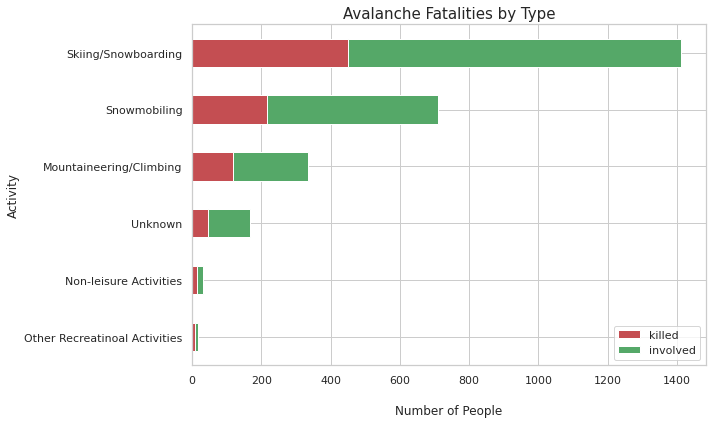

In [17]:
dat = (accidents.groupby('group_activity')
       .agg({'killed': 'sum', 'involved': 'sum'})
       .sort_values('killed'))

fig, ax = plt.subplots(figsize=(10,6))
dat.plot.barh(ax=ax, stacked=True, color=['r', 'g'])
plt.xlabel("\nNumber of People")
plt.ylabel("Activity")
plt.title("Avalanche Fatalities by Type", fontsize=15)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

It is evident that most of people involved in avalanches are either skiing or snowboarding at the time. This makes sense as skiing and snowboarding are the most common activities conducted during avalanche terrain. 
Visually, there does not appear to be an activity which has a higher proportion of deaths to total people involved in avalanches. 

Another interesting aspect of the data is the number of people involved in avalanches while snowmobiling. Although skiing is a much more popular sport in comparison to snowmobiling, the number of people involved in an avalanche when snowmobiling is about half of those when skiing. From the figure and the data itself, no inferences can be made as to why this is the case. However, we can hypothesize that this is likely the case for 2 reasons. The first reason is that most avalanches occur in the backcountry which is where most snowmobiling is done and a smaller population of skiers venture to. Another reason is likely because snowmobiles are heavier and are able to impact weak layers further down in the snowpack, triggering slab avalanches that skiers may not. This is interesting, however, as slab avalanches are generally larger and bigger so by triggering more thick slab avalanches this hypothesis would suggest a higher proportion of deaths for those involved in snowmobiling accidents.


### Number of Avalanches + Deaths grouped by Months

The bar Plot below portrays the number of avalanches and the number of deaths caused by avalanches in each month.
The purpose of this plot is to highlight whether avalanches tend to be more frequent at certain parts of the ski season than others/

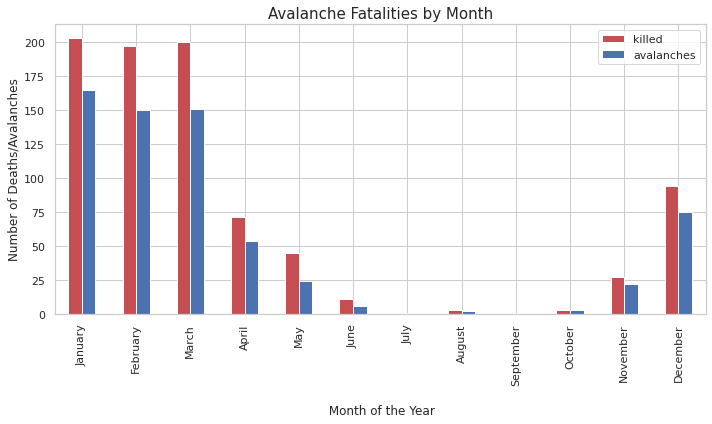

In [16]:
dat = (accidents.groupby('month')
        .agg({'killed':'sum', 'month':'size'})
        .rename(columns={'month':'avalanches'})
        .reset_index())
sort_order = ["January", "February", "March", "April", "May", "June", "July",
              "August", "September", "October", "November", "December"]
dat.index = pd.CategoricalIndex(dat['month'], categories=sort_order, ordered=True)
dat = dat.sort_index().drop(columns = ["month"])

fig, ax = plt.subplots(figsize=(10,6))
dat.plot.bar(ax=ax, color=['r', 'b'])
plt.xlabel("\n Month of the Year")
plt.ylabel("Number of Deaths/Avalanches")
plt.title("Avalanche Fatalities by Month", fontsize=15)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

From this graph it is apparent that the majority of avalanches and deaths occurred during the winter months, primarily from January through march when there is the most snow on the mountains in the northern hemisphere. This is intuitive as snow is required for an avalanche to occur. In comparison to January, the ratio of people killed to number of avalanches appears to be slightly greater in the months of February and March. however, this is likely not of any significance or representative of the entire population and just a feature of our data sample.
At the start of the ski season which is generally in November and December, there appears to be significantly less avalanches than in the following 3 months. This is likely because the snowpack is not deep enough or has not been around enough to develop many weak layers. It could also be a result of the fact that the snowpack in the mountains may not be developed in the months of November or December in some years and people therefore would not be doing any activities in avalanche territory. 
Avalanches and deaths drastically taper off in April and May. This is likely because most of the snow is melting or has melted in these months.

### Fatalities by State in the US, by Province in Canada & by Country in Europe
#### The setup:
*  3 dataframes are created and filtered for their own region: United States, Canada and Europe.
* United States is grouped by its states to show total number of deaths caused by avalanches in each state.
* Canada is grouped by its provinces to show total number of deaths caused by avalanches in each province.
* Europe is grouped by its countries to show total number of deaths caused by avalanches in each country.
* This helps us to visualize on the countries/states/provinces in each of these regions where avalanches pose higher risks

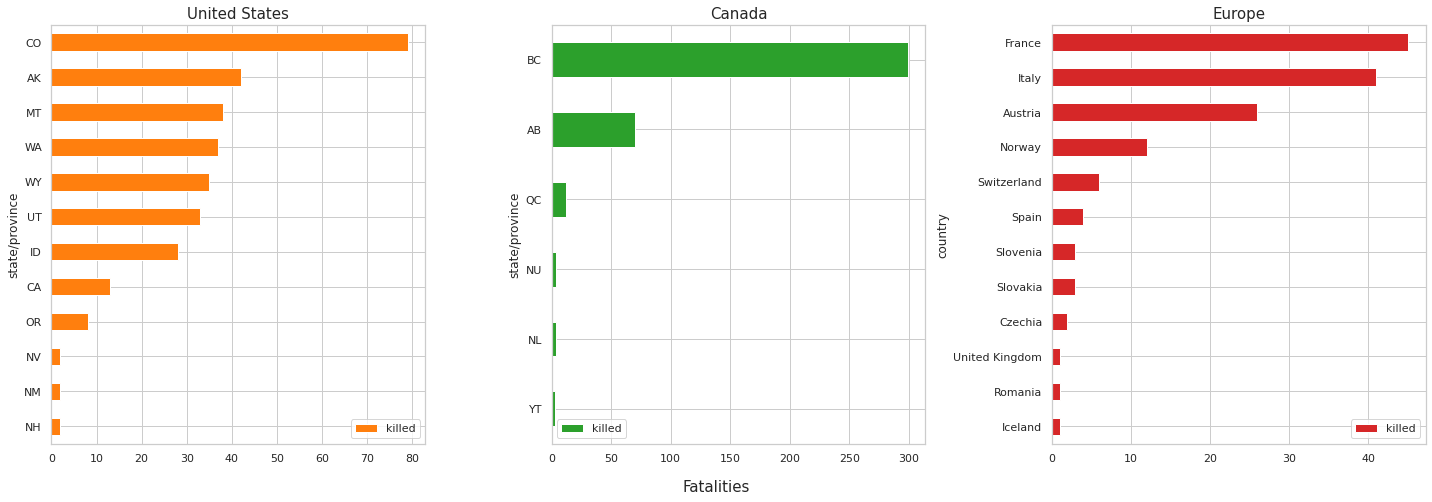

In [18]:
dat1 = (accidents.loc[(accidents['country']=='United States')]
       .groupby('state/province')
       .agg({'killed': 'sum'})
       .sort_values('killed'))
dat2 = (accidents.loc[(accidents['country']=='Canada')]
       .groupby('state/province')
       .agg({'killed': 'sum'})
       .sort_values('killed'))
dat3 = (accidents.loc[(accidents['country']!='Canada') & (accidents['country']!='United States')]
       .groupby('country')
       .agg({'killed': 'sum'})
       .sort_values('killed'))

fig, axs = plt.subplots(1, 3, figsize=(20,7))
dat1.plot.barh(ax=axs[0], color='tab:orange')
axs[0].set_title("United States", fontsize=15)
dat2.plot.barh(ax=axs[1], color='tab:green')
axs[1].set_title("Canada", fontsize=15)
dat3.plot.barh(ax=axs[2], color='tab:red')
axs[2].set_title("Europe", fontsize=15)
fig.supxlabel('Fatalities', fontsize=15)
plt.tight_layout()
plt.show()

From the figure using data from the United States, it is evident that Colorado has the largest quantity of deaths. Most other states which contain large mountain ranges are relatively similar in the amounts of deaths caused by avalanches. From the graph it appears that states more associated with winter sports and mountain ranges have higher numbers of avalanche deaths.
It is also visually apparent from the Canadian data set that the number of deaths caused by avalanches is the greatest for British Columbia, followed not so closely by Alberta and all other provinces or territories have very few numbers in comparison. This is likely for 2 reasons. the first reason is that Mountain ranges extend across British Columbia and are only seen in the western part of Alberta. additionally, avalanches are less likely to be seen in less populated Territories like Nunavut and the Yukon as there are less people venturing into avalanche territory.
Looking at the European Data, the vast majority of avalanche caused deaths occur in countries that contain the Alps mountain range. The reason for the distribution of number of deaths across Europe is likely for the same reasons as the distribution of deaths in Canada. countries with less avalanche territory or smaller populations appear to have less avalanche-caused deaths.

### Avalanche Fatalities by Year

* For this plot, we decided on creating 2 subplots, one representing the total deaths each year in Canada while the other represents the combined total deaths each year in all three regions (USA, Canada & Europe).
* We also display the 3-year moving average line for each subplot in order to give a better representation of the trend.

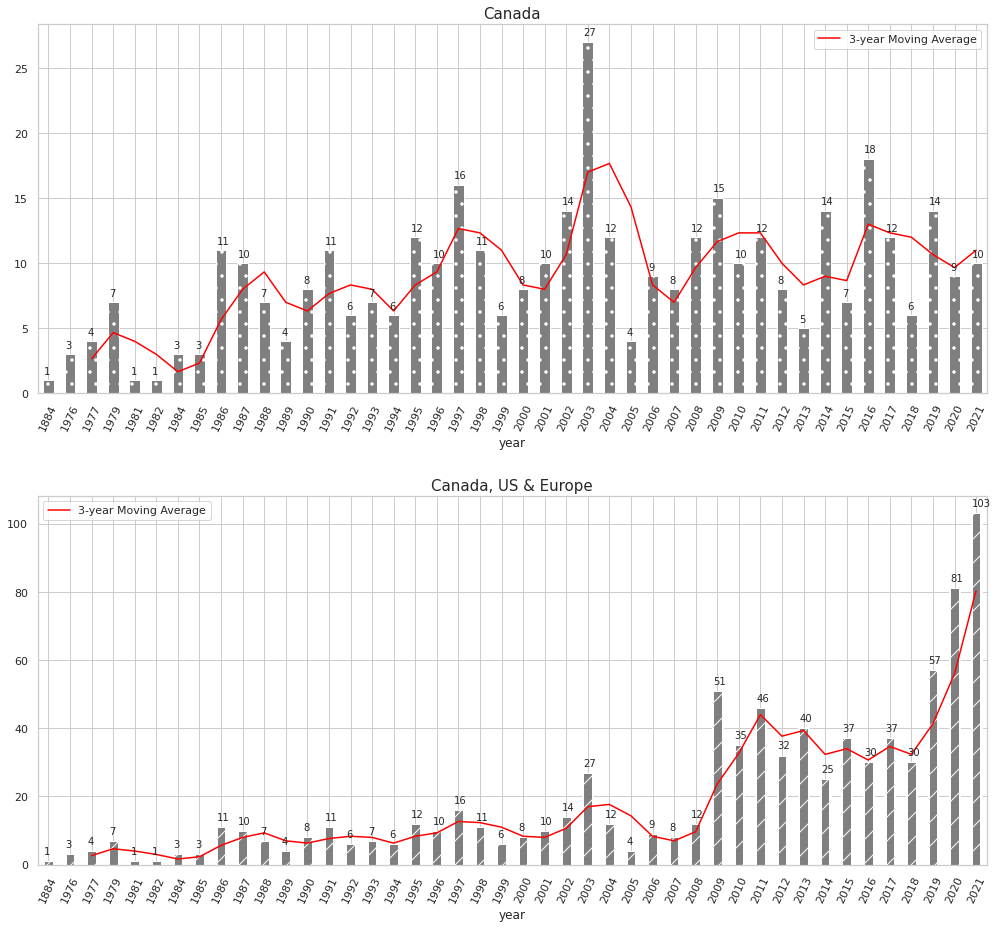

In [12]:
dat1 = (accidents
        .loc[(accidents['country']=='Canada')]
        .groupby('year')
        .agg({'killed': 'sum'})
        .sort_values('year'))

dat2 = (accidents
        .groupby('year')
        .agg({'killed': 'sum'})
        .sort_values('year'))

fig, axs = plt.subplots(2, 1, figsize=(14,13))
dat1.plot.bar(ax=axs[0], color='tab:gray', legend=None, hatch='.')
bars = plt.bar(dat1.index, height=dat1.killed, width=.4)
for bar in bars:
    yval = bar.get_height()
    axs[0].text(bar.get_x(), yval+0.5, yval)
dat1.rolling(3).mean().plot.line(ax=axs[0], color="red")
axs[0].set_title("Canada", fontsize=15)
axs[0].tick_params(axis='x', rotation=65)
axs[0].legend(['3-year Moving Average'])

dat2.plot.bar(ax=axs[1], color='w', legend=None)
bars = plt.bar(dat2.index, height=dat2.killed, width=.4, color='tab:gray', hatch = '/')
for bar in bars:
    yval = bar.get_height()
    axs[1].text(bar.get_x(), yval+2, yval)
dat2.rolling(3).mean().plot.line(ax=axs[1], color="red")
axs[1].set_title("\nCanada, US & Europe", fontsize=15)
axs[1].tick_params(axis='x', rotation=65)
axs[1].legend(['3-year Moving Average'])


plt.tight_layout()
plt.show()

In Canada, there does not appear to be a distinct trend of the number of avalanche deaths by year. One possible explanation for this is that the weather conditions are not consistent each year and some years may be particularly worse for avalanches than others.

When combining the data across all investigated regions of the US, Canada and Europe, it does appear that over time the number of avalanche related deaths has drastically increased. A possible explanation for this is that in the 21st century, exploring uncontrolled avalanche territory has become more common. 

## Predictive Modelling

* Now that most of the data visualization is done, we move on to building predictive models.
* It should be pointed out that  **only** the `ca_incidents` data will be used for predictive analysis due to the fact that this data has the least `NaN` values, the highest number of observations and most importantly several columns which are of interest in terms of predicting the response. 
* the aim is to develop and compare two different prediction methods: **Random Forests** and **Lasso Regression**.
* Dropping all the `NaN` values in the data results in a smaller dataframe, and therefore less complex models will need to be used (i.e. fewer features / bigger penalty for lasso, less deep trees).
* Therefore, cross-validation has to be performed as it is designed to tune the parameters of the predictive models by discovering the most significant/efficient predictor variables which maximize prediction accuracy.
* The aforementioned prediction models will be used to predict the number of casualties (deaths) given the predictor variables: `involved`, `group_activity`, `size`, `type`, `aspect`, `elevation`, `slab_width`, `slab_thickness`.
    * below is a brief description of these variables:
        * involved: number of people involved in the avalanche
        * group_activity: activity conducted by the people at the time of the avalanche
        * size: size of avalanche
        * type: type of avalanche
        * aspect: the aspect of the slope
        * elevation: elevation above sea-level
        * slab_width: how wide the slab of the avalanche was
        * slab_thickness: how thick the slab avalanche was
* It is decided that data will be split into **20% training set** and **80% test set**.
* This is done because the training data helps create the "best" model via cross validation with validation sets and in order to test our model's prediction capabilities on "new" data, the outcomes are predicted on the test data and compared to the true outcomes.

### Data Preprocessing

* Begin by copying the `ca_incidents` data.
* Select only the columns of interest, clean the data by removing all `NaN` values and then reset the index to create consistent indexing.
* Since there are some categorical variables with multiple factors, when creating matrices out of these variables, parsing errors may occur as some strings can not be converted into integers. To prevent this issue, encode all the data which was categorized as `dtype:object`.

In [13]:
avalanche = ca_incidents.copy()
avalanche = avalanche.iloc[:,[3,5,7,8,9,11,12,13,14]].dropna().reset_index().drop(columns = 'index')

le = preprocessing.LabelEncoder()
for column_name in avalanche.columns:
    if avalanche[column_name].dtype == object:
        avalanche[column_name] = le.fit_transform(avalanche[column_name])
    else:
        pass

The data is now split into training and test sets:

In [14]:
train = avalanche.sample(frac=0.8,random_state=123) 
test = avalanche.drop(train.index)

* A numeric matrix of features is created from our dataframe. 
* The formula interface from the patsy package is one convenient method for doing this.

In [15]:
y, X = patsy.dmatrices("killed ~ involved + C(group_activity) + size + C(type) + C(aspect) + elevation + slab_width + slab_thickness"
                       , avalanche, return_type='matrix')
y = y.flatten()
train.index
y_train = y[train.index]
X_train = X[train.index]
y_test = y[test.index]
X_test = X[test.index]

### Lasso Regression
* Fit a lasso model to the training data.
* Use cross-validation to choose the regularization parameter alpha.
* Print the MSE on the training and testing data.

In [19]:
# LassoCV exploits special structure of lasso problem to minimize CV more efficiently
lasso = linear_model.LassoCV(cv=5).fit(X_train,y_train)
alpha = lasso.alpha_ # gives us the minimizer

def fit_and_report_mses(mod, X_train, X_test, y_train, y_test):
    mod.fit(X_train, y_train)
    return dict(
        mse_train=metrics.mean_squared_error(y_train, mod.predict(X_train)),
        mse_test=metrics.mean_squared_error(y_test, mod.predict(X_test))
    )

fit_and_report_mses(linear_model.Lasso(alpha=alpha, max_iter=50000), X_train, X_test, y_train, y_test)

{'mse_train': 0.5444505342000605, 'mse_test': 0.5712232027849914}

### Random Forests

* We fit a random forest to the training data.
* Use cross-validation to select the maximum tree depth.
* Finally, print the MSE on the training and testing data. 

In [20]:
param_grid = { 'max_depth': [1, 2, 4, 8, 16, None] } # depths to try, you could change this
rf_grid = sklearn.model_selection.GridSearchCV(sklearn.ensemble.RandomForestRegressor(n_estimators=25), 
                                               param_grid, cv=6, scoring='neg_mean_squared_error')
rf_grid.fit(X_train, y_train)
rf_best = rf_grid.best_estimator_ 

fit_and_report_mses(rf_best, X_train, X_test, y_train, y_test)

{'mse_train': 0.554878687739891, 'mse_test': 0.938188764871425}

## Comparison of the 2 predictive models

Lasso Regression provides a MSE on the test data of 0.5712 and Random Forests provides a MSE of 0.9382. Therefore Lasso regression proves to be a better method for predicting the avalanche deaths based on the set of predictor variables. This is likely because Lasso is better for data sets with fewer data points and trees have poor prediction power. Overall lasso regression is the preferred method for predicting avalanche deaths for the Canadian avalanche data. 

## Conclusion:

Through the exploratory analysis, it was discovered that avalanche deaths are most common among skiers and snowboarders. For further investigation, it is suggested to investigate the number of avalanche deaths per activity as a proportion of the number of people who do those activities each year. This would depict which activity is more likely to trigger a deadly avalanche. 

The exploratory analysis also suggests that deadly avalanches are most common during the middle of the ski season and less common at the beginning and the ends of the season. Avalanche deaths were also seen to be more common primarily in areas with more avalanche-prone terrain and also appeared to be more frequent in areas with greater populations. \Finally, the exploratory analysis was unable to find a trend in avalanche deaths over the course of multiple years in Canada, however when the data from Canada, The United States and Europe are combined, there does appear to be an increase in avalanche deaths over time. An improvement for the exploratory analysis would be to collect metrics on the number of individuals who do different activities and the number of people in different avalanche-prone locations. This would allow for more solidified results rather than inferences as to whether the type of activity or the location itself is more dangerous when it comes to avalanches or whether more deaths are occurring simply due to specific activities being more popular or more people venturing into avalanche prone areas.

For the predictive modeling comparison, the prediction methods of Lasso regression and Random Forests were compared to determine which was a better prediction method for the number of deaths caused by an avalanche given information about the avalanche itself. The comparison of Lasso Regression and Random Forests as prediction techniques for the number of deaths caused by avalanches suggests that Lasso regression is a better method for predicting avalanche deaths based on the metrics collected about the avalanches as it provides a smaller MSE.

## References:

- “Avalanche.org " Accidents.” Avalanche.org, Colorado Avalanche Information Center, 5 Feb. 2020, https://avalanche.org/avalanche-accidents/. 
- “Fatalities.” EAWS, 25 Nov. 2021, https://www.avalanches.org/fatalities/fatalities-20/. 
- “Historical Incidents.” Avalanche Canada, https://www.avalanche.ca/incidents. 